**Transfer Learning** is a Deep Learning technique where we use a pre-trained model. This pre-trained model is trained for one task can be re-trained for a similar task with a smaller dataset

**Transfer Learning** gives higher accuracy compared training models from scratch

Examples of Pre-Trained Models:
- VGG-16
- ResNet50
- Inception V3
- MobileNet V2

## Work Flow

Dataset -> Image Processing -> Train Test Split -> Pretrained MobileNet Model

New Image -> Model -> Prediction

# 1. Data Preparation
Link: https://www.kaggle.com/c/dogs-vs-cats

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 805M/812M [00:10<00:00, 86.6MB/s]
100% 812M/812M [00:10<00:00, 80.3MB/s]


1.1. Unzip `dogs-vs-cats.zip` and test

In [4]:
!ls

dogs-vs-cats.zip  kaggle.json  sample_data


In [5]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [ ]:
!unzip train.zip
!unzip test1.zip

In [7]:
!rm -r train.zip
!rm -r test1.zip

### 1.2. Image to Dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
all_train_imgs = os.listdir('/content/train')
labels = []
for img_file in all_train_imgs:
  if 'cat' in img_file:
    labels.append('cat')
  if 'dog' in img_file:
    labels.append('dog')

df = pd.DataFrame({
    'index': range(len(labels)),
    'filepath': all_train_imgs,
    'label': labels
})

df.head()

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/train'

### 1.3. Display images

In [10]:
NUM_ROWS = 2
NUM_COLS = 4

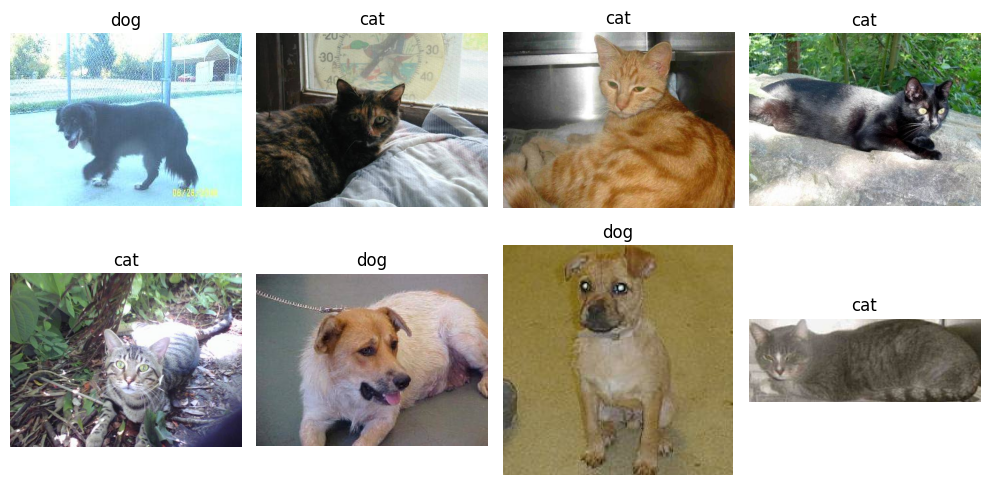

In [11]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(NUM_ROWS, NUM_COLS, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
  filepath = df.iloc[i]['filepath']
  img = plt.imread(os.path.join('/content/train', filepath))
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(df.iloc[i]['label'])
plt.tight_layout()
plt.show()


## 2. Data Preprocessing
Convert folder of data into processed data, ready to train.
Using `ImageDataGenerator` with the function `flow_from_dataframe()` or `flow_from_dictionary()`

In [12]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [13]:
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
BATCH_SIZE = 32

In [14]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/train/',
    x_col='filepath',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    subset='training'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory='/content/train/',
    x_col='filepath',
    y_col='label',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    subset='validation'
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [15]:
train_generator

In [16]:
valid_generator

## 3. Model

In [6]:
import tensorflow as tf
from tensorflow import keras
IMAGE_WIDTH, IMAGE_HEIGHT = 224, 224
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))

58889256/58889256 [==============================] - 13s 0us/step


In [7]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
for layer in base_model.layers:
  layer.trainable = False

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


## 4. Train Model

In [14]:
history = model.fit(train_generator, epochs=5, validation_data=valid_generator)

NameError: name 'train_generator' is not defined

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

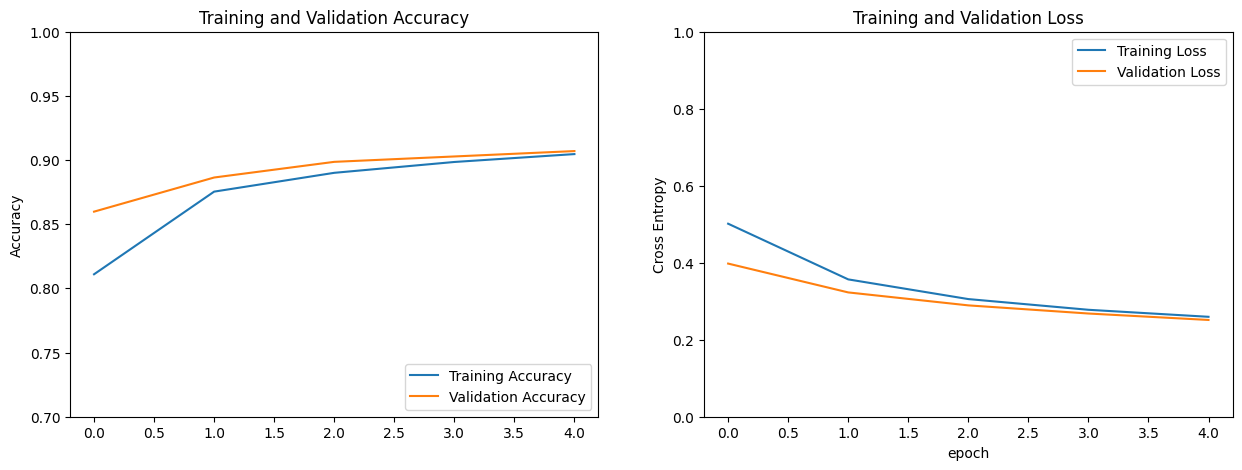

In [39]:
# prompt: visualize accuracy, loss of train and valid from previous training using plt, subplot, with clear size, the accuracy graph start from 0 and end with 1 (at the y axis)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [40]:
model.save('vgg16_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
vgg16_model = tf.keras.models.load_model('vgg16_model.h5')

In [55]:
all_test_imgs = os.listdir('/content/test1')

In [54]:
df_test = pd.DataFrame({
    'index': range(len(all_test_imgs)),
    'filepath': ['/content/test1/' + x for x in all_test_imgs]
})

df_test.head()

,index,filepath
0,0,/content/test1/4736.jpg
1,1,/content/test1/350.jpg
2,2,/content/test1/11942.jpg
3,3,/content/test1/12346.jpg
4,4,/content/test1/11577.jpg


In [77]:
NEW_SAMPLE_PATH = '/content/test1/11942.jpg'

1/1 [==============================] - 0s 64ms/step
[[0.]]


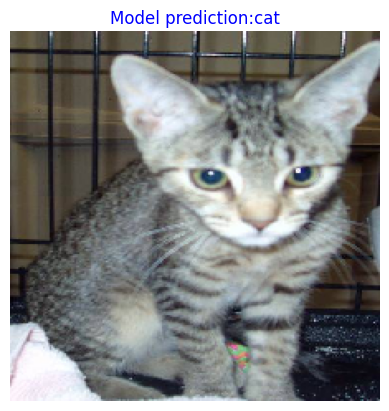

In [79]:
try:
    new_sample_image = tf.keras.preprocessing.image.load_img(NEW_SAMPLE_PATH, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    new_sample_image = tf.keras.preprocessing.image.img_to_array(new_sample_image)
    new_sample_image = np.expand_dims(new_sample_image, axis=0)
    new_sample_image = tf.keras.applications.vgg16.preprocess_input(new_sample_image)
    prediction = vgg16_model.predict(new_sample_image)
    print(prediction)
except:
    print('Error dufing preprocessing or prediction')

if prediction[0][0] > 0.5:
    predict_label = 'dog'
if prediction[0][0] <= 0.5:
    predict_label = 'cat'

image = tf.keras.preprocessing.image.load_img(NEW_SAMPLE_PATH, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))

# Display the image with title and caption
plt.imshow(image)
plt.title('Model prediction:' + predict_label, color='b')
plt.axis('off')
plt.show()